In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

data = yf.download(tickers='BTC-USD', start='2018-12-01', end='2024-07-25')
data.head(10)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-01,4024.464355,4309.377441,3969.710693,4214.671875,4214.671875,5375314093
2018-12-02,4200.733398,4301.519531,4110.978516,4139.877930,4139.877930,5262697895
2018-12-03,4147.323730,4155.979492,3840.446289,3894.130859,3894.130859,5089570994
2018-12-04,3886.294922,4075.627686,3832.750000,3956.893799,3956.893799,5028069239
2018-12-05,3958.894775,3969.535889,3753.994873,3753.994873,3753.994873,5302481574
2018-12-06,3754.074463,3874.966064,3521.101807,3521.101807,3521.101807,5878333109
2018-12-07,3512.590332,3512.590332,3280.228760,3419.937256,3419.937256,6835615448
2018-12-08,3421.910400,3506.043457,3350.650635,3476.114746,3476.114746,5305024497
2018-12-09,3473.227539,3685.305664,3469.094238,3614.234375,3614.234375,4947372847


In [63]:
! pip install pandas_ta

In [64]:
import pandas_ta as ta

data['RSI'] = ta.rsi(data['Close'], length=15)
macd = ta.macd(data['Close'])
data['MACD'] = macd['MACD_12_26_9']
data['MACD_Signal'] = macd['MACDs_12_26_9']
data['MACD_Hist'] = macd['MACDh_12_26_9']
bbands = ta.bbands(data['Close'], length=20)
data['BB_MAVG'] = bbands['BBM_20_2.0']
data['BB_UPPER'] = bbands['BBU_20_2.0']
data['BB_LOWER'] = bbands['BBL_20_2.0']
stoch = ta.stoch(data['High'], data['Low'], data['Close'], length=14)
data['SO'] = stoch['STOCHk_14_3_3']
data['SO_Signal'] = stoch['STOCHd_14_3_3']
data['SMA'] = ta.sma(data['Close'], length=10)
data['NextClose'] = data['Adj Close'].shift(-1)
data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)

data.head(10)
print(data.columns)


Index(['Open', 'High', 'Low', 'Adj Close', 'RSI', 'MACD', 'MACD_Signal',
       'MACD_Hist', 'BB_MAVG', 'BB_UPPER', 'BB_LOWER', 'SO', 'SO_Signal',
       'SMA', 'NextClose'],
      dtype='object')


In [65]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values)
training_data_len = int(np.ceil(len(scaled_data) * 0.65))

train_data = scaled_data[0:int(training_data_len), :]
test_data = scaled_data[int(training_data_len):, :]

def create_dataset(data, time_step=10):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, -1])
    return np.array(X), np.array(y)

time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (1308, 10, 15)
y_train shape:  (1308,)
X_test shape:  (699, 10, 15)
y_test shape:  (699,)


In [66]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import History
from keras.models import load_model

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(days, scaled_data.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


In [67]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
21/21 [==============================] - 15s 292ms/step - loss: 0.0262 - val_loss: 0.0029
Epoch 2/50
21/21 [==============================] - 2s 107ms/step - loss: 0.0049 - val_loss: 0.0026
Epoch 3/50
21/21 [==============================] - 2s 79ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 4/50
21/21 [==============================] - 2s 75ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 5/50
21/21 [==============================] - 2s 77ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 6/50
21/21 [==============================] - 1s 62ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 7/50
21/21 [==============================] - 2s 74ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 8/50
21/21 [==============================] - 1s 63ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 9/50
21/21 [==============================] - 2s 96ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 10/50
21/21 [==============================] - 2s 102ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch

In [69]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

model.save('btc_price_prediction_model.h5')
model = load_model('btc_price_prediction_model.h5')

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

def inverse_transform_predictions(predictions, scaler, num_features):
    predictions_with_zeros = np.hstack((np.zeros((predictions.shape[0], num_features - 1)), predictions))
    return scaler.inverse_transform(predictions_with_zeros)[:, -1]

train_predict = inverse_transform_predictions(train_predict, scaler, scaled_data.shape[1])
test_predict = inverse_transform_predictions(test_predict, scaler, scaled_data.shape[1])

y_train = inverse_transform_predictions(y_train.reshape(-1, 1), scaler, scaled_data.shape[1])
y_test = inverse_transform_predictions(y_test.reshape(-1, 1), scaler, scaled_data.shape[1])


train_mse = np.mean(np.square(y_train - train_predict))
train_rmse = np.sqrt(train_mse)
train_mae = np.mean(np.abs(y_train - train_predict))

test_mse = np.mean(np.square(y_test - test_predict))
test_rmse = np.sqrt(test_mse)
test_mae = np.mean(np.abs(y_test - test_predict))

print(f'Train MSE: {train_mse}, Train RMSE: {train_rmse}, Train MAE: {train_mae}')
print(f'Test MSE: {test_mse}, Test RMSE: {test_rmse}, Test MAE: {test_mae}')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 0s 6ms/step
Train MSE: 4815218.50420433, Train RMSE: 2194.3606139840213, Train MAE: 1434.7932156657946
Test MSE: 4902075.4656258, Test RMSE: 2214.0631123854173, Test MAE: 1837.6967705232312


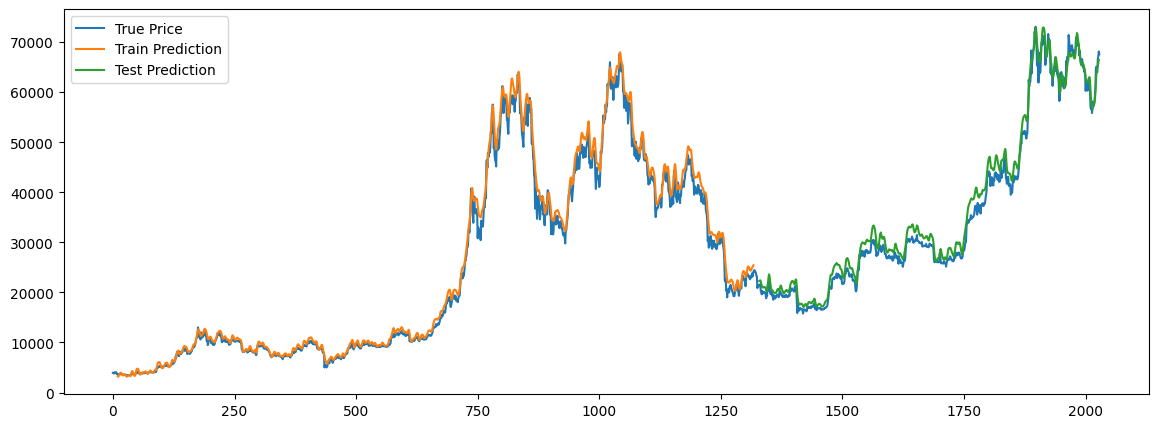

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(data['Open'], label='True Price')

train_pred_plot = np.empty_like(data['Open'])
train_pred_plot[:] = np.nan
train_pred_plot[time_step:len(train_predict) + time_step] = train_predict

test_pred_plot = np.empty_like(data['Open'])
test_pred_plot[:] = np.nan
test_pred_plot[len(train_predict) + (time_step*2) + 1:len(data) - 1] = test_predict

plt.plot(train_pred_plot, label='Train Prediction')
plt.plot(test_pred_plot, label='Test Prediction')
plt.legend()
plt.show()

In [78]:
model = load_model('btc_price_prediction_model.h5')

block_size = 10
last_days = scaled_data[-block_size:]

X_pred = np.array([last_days])
X_pred = np.reshape(X_pred, (X_pred.shape[0], X_pred.shape[1], X_pred.shape[2]))

predicted_prices = []
predicted_value = model.predict(X_pred)
predicted_prices.append(predicted_value[0])
new_feature = np.zeros((1, X_pred.shape[2]))
new_feature[0, -1] = predicted_value[0, 0]
new_input = np.append(X_pred[0][1:], new_feature, axis=0)
X_pred = np.array([new_input])


def inverse_transform_predictions(predictions, scaler, num_features):
    predictions_with_zeros = np.hstack((np.zeros((predictions.shape[0], num_features - 1)), predictions))
    return scaler.inverse_transform(predictions_with_zeros)[:, -1]

predicted_prices = np.array(predicted_prices)
predicted_prices = inverse_transform_predictions(predicted_prices, scaler, scaled_data.shape[1])

print("Future Prediction: ", predicted_prices[0])

1/1 [==============================] - 1s 828ms/step
Future Prediction:  66286.61810206797
